<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day4/Day_4_3_RNN_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4.2 RNN Basic
### 실습 목표
- RNN 모델을 정의해보고, 이를 이용한 분류기를 구현해보자

### Contents
1. RNN 모델의 입력 데이터 형태
2. RNN 모델 정의
  1. vanila RNN
  2. LSTM
  3. GRU
3. RNN을 이용한 분류기 구현
4. 연습문제

## 0. Setting
- DL 관련 library 호출
- GPU 설정

In [20]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


# 1. RNN 모델의 입력 데이터 형태

- ![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbocVaf%2FbtqC48TSP1V%2Fgu9CyjxwKjUU8AtSVEyoYK%2Fimg.png)

In [3]:
# singleton example
# shape : (1, 1, 4)
# input_data_np = np.array([[[1, 0, 0, 0]]])

# sequential example
# shape : (3, 5, 4)
# (batch size, seq length, input_size)
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]
input_data_np = np.array([[h, e, l, l, o],
                          [e, o, l, l, l],
                          [l, l, e, e, l]], dtype=np.float32)  # (3, 5, 4)

In [4]:
# transform as torch tensor
input_data = torch.Tensor(input_data_np)
input_data

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

# 2. RNN 모델 정의
- `input_size`: 입력해 주는 특성 값의 개수
- `hidden_size`: hidden state의 사이즈 지정. 보통 arbitrary 함.
- `batch_first`: 입력으로 받는 데이터의 shape중 첫 번째 차원을 batch로 간주할 것인지를 설정.
  - True: (batch, seq, feature)
  - False: (seq, batch, feature)

## 2.1 Vanila RNN
![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbhdv8j%2FbtqC3NCHkYS%2FL5Y5s2WLKKfH9PlLxoy3w0%2Fimg.png)

In [5]:
# declare dimension
input_size = 4
hidden_size = 3
# declare RNN
rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)  # 처음에 batch_size or seq_length

In [6]:
input_data.shape

torch.Size([3, 5, 4])

In [10]:
# check output
outputs, _status = rnn(input_data)
# inputs: input, h_0 = 0 (num_layers*num_directions, batch, hidden_size)
print("outputs:\n", outputs)
print("outputs size:",outputs.size())
print()
# shape : (3, 5, 3)
# (batch_size, seq_length, hidden_dim)

print("hidden states:\n", _status)
print("hidden state size:",_status.size())
# shape: (1, 3, 3)
# (num_layers, batch_size, hidden_dim)

outputs:
 tensor([[[-0.5792,  0.7667,  0.6779],
         [-0.8956,  0.9194,  0.2946],
         [-0.9098,  0.8468,  0.1630],
         [-0.8951,  0.8590,  0.1286],
         [-0.6311,  0.8501, -0.0309]],

        [[-0.5701,  0.9043,  0.2403],
         [-0.5962,  0.7854, -0.0213],
         [-0.8418,  0.8276,  0.0322],
         [-0.8760,  0.8592,  0.0627],
         [-0.8845,  0.8614,  0.0674]],

        [[-0.6114,  0.7141,  0.3371],
         [-0.8762,  0.7986,  0.2504],
         [-0.8831,  0.9518,  0.0888],
         [-0.8815,  0.9555, -0.0661],
         [-0.8810,  0.8699, -0.0443]]], grad_fn=<TransposeBackward1>)
outputs size: torch.Size([3, 5, 3])

hidden states:
 tensor([[[-0.6311,  0.8501, -0.0309],
         [-0.8845,  0.8614,  0.0674],
         [-0.8810,  0.8699, -0.0443]]], grad_fn=<StackBackward0>)
hidden state size: torch.Size([1, 3, 3])


### Tracking the model parameters
- 신경망 내부의 많은 계층들은 매개변수화(parameterize) 됨.
- 학습 중에 최적화되는 가중치와 편향과 연관지어 짐.
- `named_parameters()`: 각 매개변수들을 순회하며(iterate), 매개변수의 크기와 값을 출력

In [11]:
[(name, param.shape) for name, param in rnn.named_parameters()]

[('weight_ih_l0', torch.Size([3, 4])),
 ('weight_hh_l0', torch.Size([3, 3])),
 ('bias_ih_l0', torch.Size([3])),
 ('bias_hh_l0', torch.Size([3]))]

## 2.2 LSTM
![image.png](https://miro.medium.com/max/1400/1*z7bEceNfH6X_N75HA9kyoA.webp)


In [13]:
lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
outputs, _status = lstm(input_data)
print(outputs)
print(outputs.size())
print()

print(_status[0])
print(_status[0].shape)

tensor([[[ 0.0878, -0.0397, -0.2037],
         [ 0.1321, -0.0489, -0.1149],
         [ 0.2907, -0.0440,  0.0724],
         [ 0.3136, -0.0389,  0.1333],
         [ 0.0967, -0.1035,  0.0286]],

        [[ 0.1135, -0.0487, -0.0368],
         [ 0.0628, -0.1156, -0.0099],
         [ 0.2439, -0.1070,  0.0932],
         [ 0.2920, -0.0748,  0.1347],
         [ 0.3109, -0.0594,  0.1514]],

        [[ 0.2223, -0.0454,  0.1000],
         [ 0.2888, -0.0481,  0.1376],
         [ 0.1425, -0.0543,  0.0404],
         [ 0.1375, -0.0642, -0.0111],
         [ 0.2904, -0.0586,  0.1011]]], grad_fn=<TransposeBackward0>)
torch.Size([3, 5, 3])

tensor([[[ 0.0967, -0.1035,  0.0286],
         [ 0.3109, -0.0594,  0.1514],
         [ 0.2904, -0.0586,  0.1011]]], grad_fn=<StackBackward0>)
torch.Size([1, 3, 3])


In [14]:
[(name, param.shape) for name, param in lstm.named_parameters()]

[('weight_ih_l0', torch.Size([12, 4])),
 ('weight_hh_l0', torch.Size([12, 3])),
 ('bias_ih_l0', torch.Size([12])),
 ('bias_hh_l0', torch.Size([12]))]

## 2.3 GRU
![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/1920px-Gated_Recurrent_Unit%2C_base_type.svg.png)


In [15]:
gru = torch.nn.GRU(input_size, hidden_size, batch_first=True)
outputs, _status = gru(input_data)
print(outputs)
print(outputs.size())
print()

print(_status)
print(_status.size())

tensor([[[ 0.2232,  0.0524, -0.2916],
         [ 0.5843, -0.1140, -0.1399],
         [ 0.5073,  0.1323, -0.2245],
         [ 0.5256,  0.2808, -0.2509],
         [ 0.4877,  0.0790, -0.6061]],

        [[ 0.5127, -0.1425,  0.0452],
         [ 0.4316, -0.1522, -0.4677],
         [ 0.5284,  0.0984, -0.3591],
         [ 0.5463,  0.2517, -0.3075],
         [ 0.5531,  0.3473, -0.2818]],

        [[ 0.4164,  0.2675, -0.1320],
         [ 0.5074,  0.3707, -0.2074],
         [ 0.6539,  0.0714, -0.0925],
         [ 0.6693, -0.1107, -0.0458],
         [ 0.5091,  0.1334, -0.1871]]], grad_fn=<TransposeBackward1>)
torch.Size([3, 5, 3])

tensor([[[ 0.4877,  0.0790, -0.6061],
         [ 0.5531,  0.3473, -0.2818],
         [ 0.5091,  0.1334, -0.1871]]], grad_fn=<StackBackward0>)
torch.Size([1, 3, 3])


In [16]:
[(name, param.shape) for name, param in gru.named_parameters()]

[('weight_ih_l0', torch.Size([9, 4])),
 ('weight_hh_l0', torch.Size([9, 3])),
 ('bias_ih_l0', torch.Size([9])),
 ('bias_hh_l0', torch.Size([9]))]

# 3. RNN을 이용한 분류기 구현
## Exercise. Apply RNN to image classification(MNIST).
- RNN을 이용해 MNIST 숫자 이미지 데이터셋을 분류하는 분류기를 구현
- MNIST와 같은 이미지 데이터는 이미지의 공간(spatial) 구조를 활용하는 CNN 모델이 더 적합함.
- 하지만 인접한 영역의 픽셀은 서로 연관되어 있으므로 이를 시퀀스 데이터로 볼 수도 있음
- 아래의 그림처럼 MNIST 데이터에서 28 x 28 픽셀을 시퀀스의 각원소는 28개의 픽셀을 가진 길이가 28 시퀀스 데이터로 볼 수 있음.

![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F996759475BD2ACEF18)


- root : 데이터의 경로를 넣는다.
- train : 테스트용 데이터를 가져올지 학습용 데이터를 가져올지 표시. True면 학습용 데이터.
- transform : 어떤 형태로 데이터를 불러올 지 설정.transform에 `transforms.ToTensor()`를 넣어서 일반 이미지(PIL image)를 pytorch tensor로 변환한다.
  - 일반 이미지는 0-255사이의 값을 갖고, (H, W, C)의 형태
  - pytorch는 0-1사이의 값을 가지고 (C, H, W)의 형태
- download : True로 설정하면 MNIST 데이터가 없으면 다운.

In [18]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 241778290.31it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118644166.33it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65025258.30it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20223491.26it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



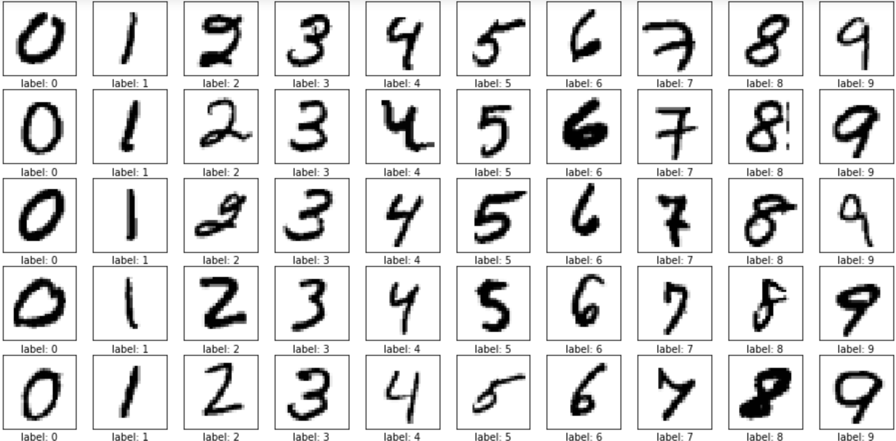

In [21]:
from multiprocessing import cpu_count

In [25]:
num_workers = int(cpu_count() / 2)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [26]:
class ImageRNN(torch.nn.Module):
    def __init__(self, batch_size, seq_length, input_size, hidden_size, num_classes, device):
        super(ImageRNN, self).__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # make rnn
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        # make fully-connected
        self.fc = torch.nn.Linear(seq_length*hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, self.seq_length, self.input_size)
        x, _hidden = self.rnn(x)
        x = x.reshape(-1, (self.seq_length * self.hidden_size))
        out = self.fc(x)

        return out

# 4. 연습문제
- Practice 1. Image를 RNN 모델의 input으로 넣을 때, `??`안의 파라미터를 정의하시오.
- Practice 2. practice1에서 정의한 파라미터로 train/test를 진행해보고 각각의 accuracy를 확인하시오.

In [27]:
# parameters
seq_length = ??
input_size = ??
hidden_size = 30
num_classes = ??
epochs = 5

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
import torch.optim as optim

In [30]:
from torch import nn

In [31]:
model = ImageRNN(batch_size, seq_length, input_size, hidden_size, num_classes, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# %%time

for epoch in range(epochs):
    # Train
    model.train()

    train_loss = 0
    train_correct = 0

    for x, y in trainloader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = train_correct / len(trainset)

    print('[%2d] TRAIN loss: %.3f, acc: %.3f' % (epoch+1, train_loss, train_acc))

[ 1] TRAIN loss: 0.376, acc: 0.891
[ 2] TRAIN loss: 0.176, acc: 0.947
[ 3] TRAIN loss: 0.130, acc: 0.961
[ 4] TRAIN loss: 0.106, acc: 0.968
[ 5] TRAIN loss: 0.092, acc: 0.972


In [33]:
# Test
model.eval()

test_loss = 0
test_correct = 0
test_preds = []

with torch.no_grad():
    for i, (x, y) in enumerate(testloader):
        x = x.view(-1, 28, 28)

        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(y).sum().item()

        if i == 0:
            test_preds = predicted
        else:
            test_preds = torch.cat((test_preds, predicted), dim=0)

test_preds = test_preds.cpu()

print('TEST loss: %.4f, acc: %.4f' % (test_loss/len(testloader), test_correct/len(testset)))

TEST loss: 0.0821, acc: 0.9747


In [34]:
print(test_preds[:20])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [35]:
print(testset.targets[:20])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
